In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re

# Step 1: Extract Trade History block
timestring = "2025-04-20_04-19-36"
path = "./backtests/"+timestring+".log"

# dir = "./r3-debrief/89779400-d017-4487-99bd-02d7e72091e1_final.log"
with open(path, "r") as f:
    lines = f.readlines()

in_trade_history = False
trade_lines = []

for line in lines:
    if line.strip() == "Trade History:":
        in_trade_history = True
        continue
    if in_trade_history:
        if line.strip() == "" or line.endswith("log:\n"):
            break
        trade_lines.append(line.strip())

# Step 2: Parse the trade history JSON array
trade_json_str = "".join(trade_lines)
trade_json_str = "}".join(trade_json_str.split(",}")) # eliminate ",}"

try:
    # Ensure it's a valid JSON array (if it’s missing brackets, wrap it)
    trade_data = json.loads(trade_json_str)
except json.JSONDecodeError as e:
    print("Error parsing trade history JSON:", e)
    exit()

# Step 3: Convert to DataFrame
df = pd.DataFrame(trade_data)
print('Done')

Done


In [11]:
# Step 4: Filter trades where SUBMISSION is buyer or seller
df = df[(df['buyer'] == 'SUBMISSION') | (df['seller'] == 'SUBMISSION')]
df

,timestamp,buyer,seller,symbol,currency,price,quantity
5,400,,SUBMISSION,KELP,SEASHELLS,2038,1
20,1100,SUBMISSION,,KELP,SEASHELLS,2037,3
21,1100,SUBMISSION,Paris,KELP,SEASHELLS,2037,1
22,1100,SUBMISSION,Caesar,KELP,SEASHELLS,2037,3
25,1200,SUBMISSION,,KELP,SEASHELLS,2036,1
...,...,...,...,...,...,...,...
18610,999200,SUBMISSION,Paris,KELP,SEASHELLS,2013,1
18611,999200,Gary,SUBMISSION,KELP,SEASHELLS,2014,9
18623,999500,SUBMISSION,Paris,RAINFOREST_RESIN,SEASHELLS,9993,2
18632,999700,SUBMISSION,Paris,KELP,SEASHELLS,2012,1


In [12]:
# Step 5: Add signed quantity (+ for buy, - for sell)
def get_signed_quantity(row):
    if row['buyer'] == 'SUBMISSION':
        return row['quantity']
    elif row['seller'] == 'SUBMISSION':
        return -row['quantity']
    return 0

df['signed_qty'] = df.apply(get_signed_quantity, axis=1)
print('Done!')

Done!


In [13]:
# Step 6: Compute cumulative position for each symbol over time
df = df.sort_values(by='timestamp')

positions = (
    df.groupby('symbol', group_keys=False)
      .apply(lambda x: x.assign(position=x['signed_qty'].cumsum()))
)

print('Done')

Done


C:\Users\Alex\AppData\Local\Temp\ipykernel_12540\3744410949.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(position=x['signed_qty'].cumsum()))


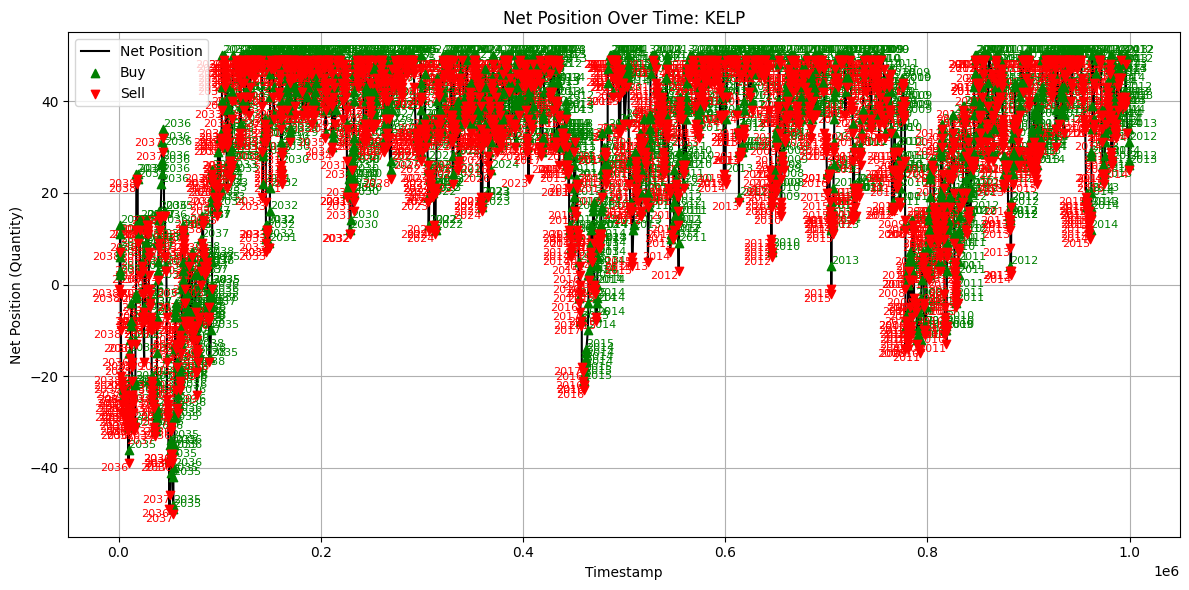

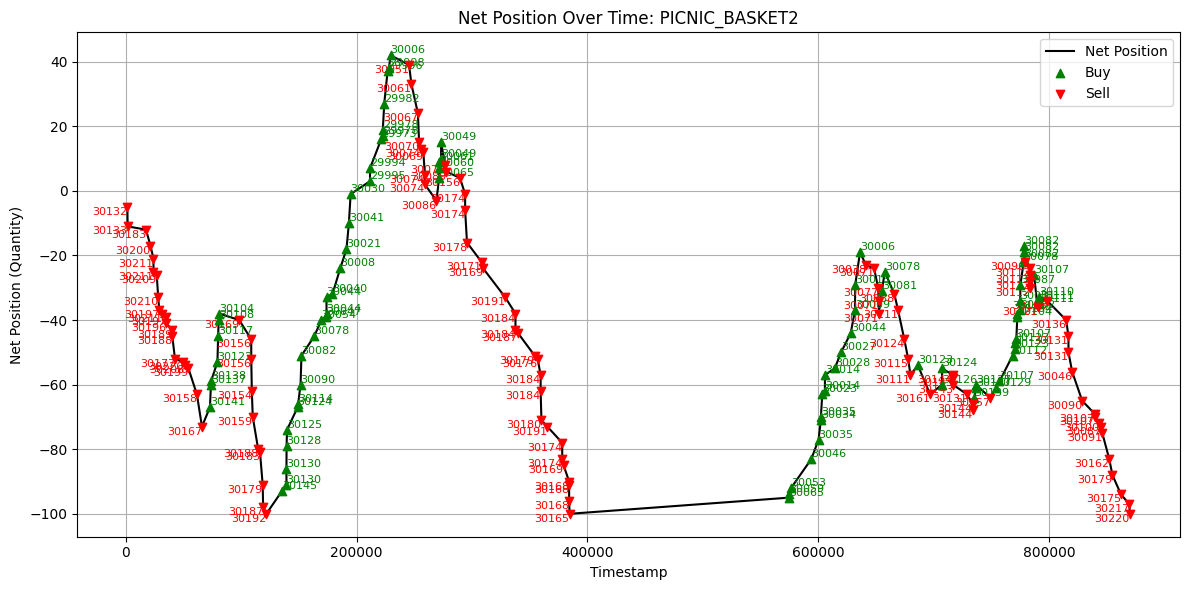

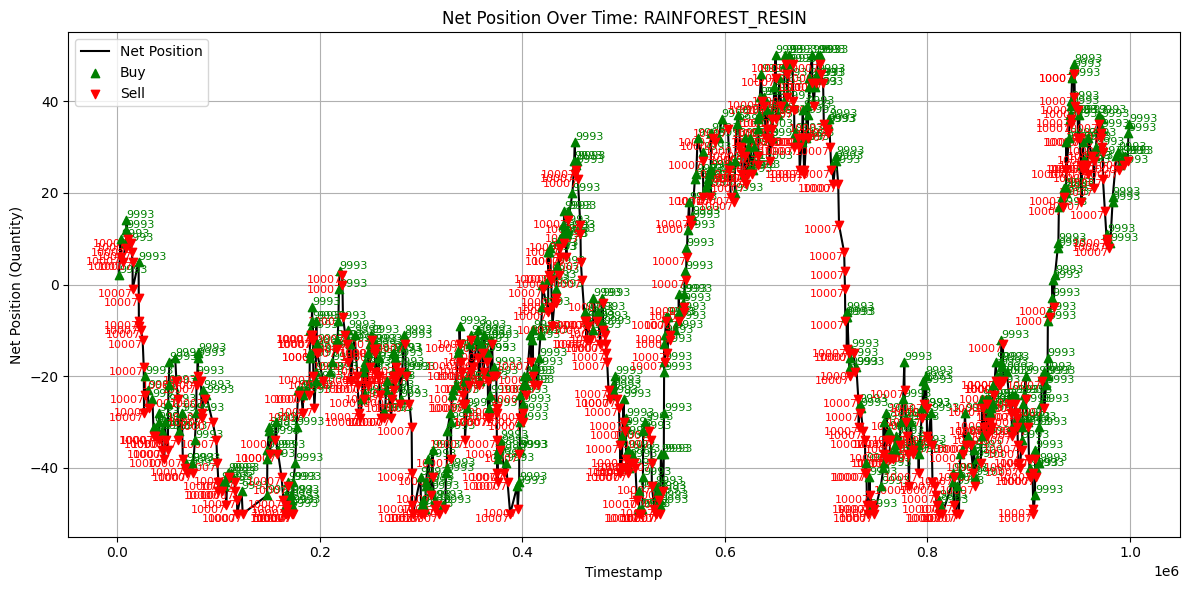

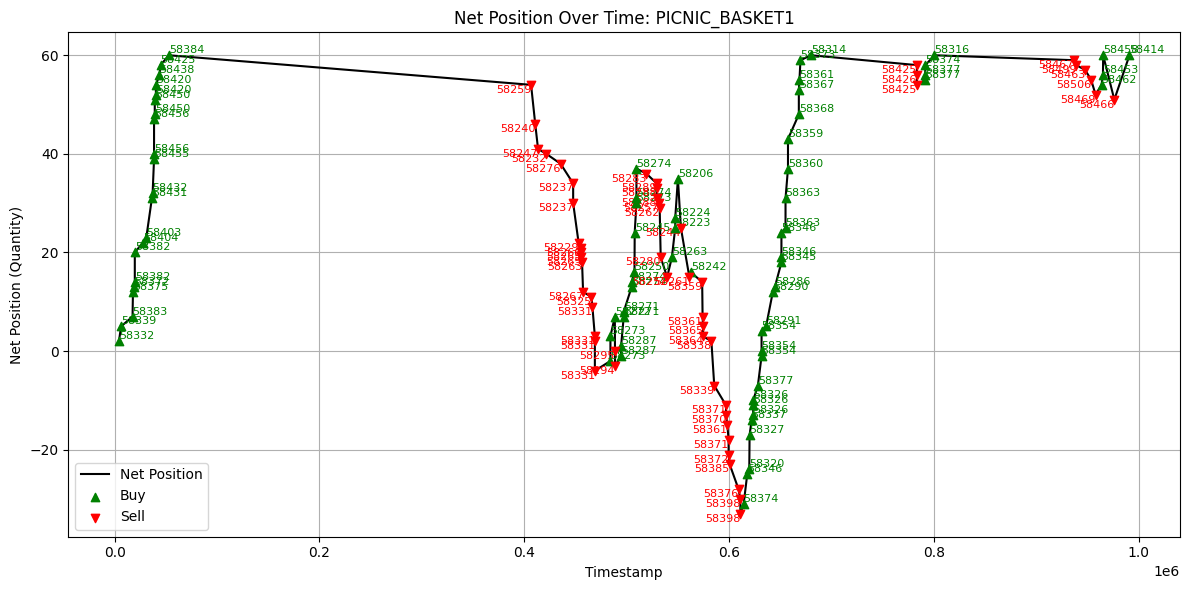

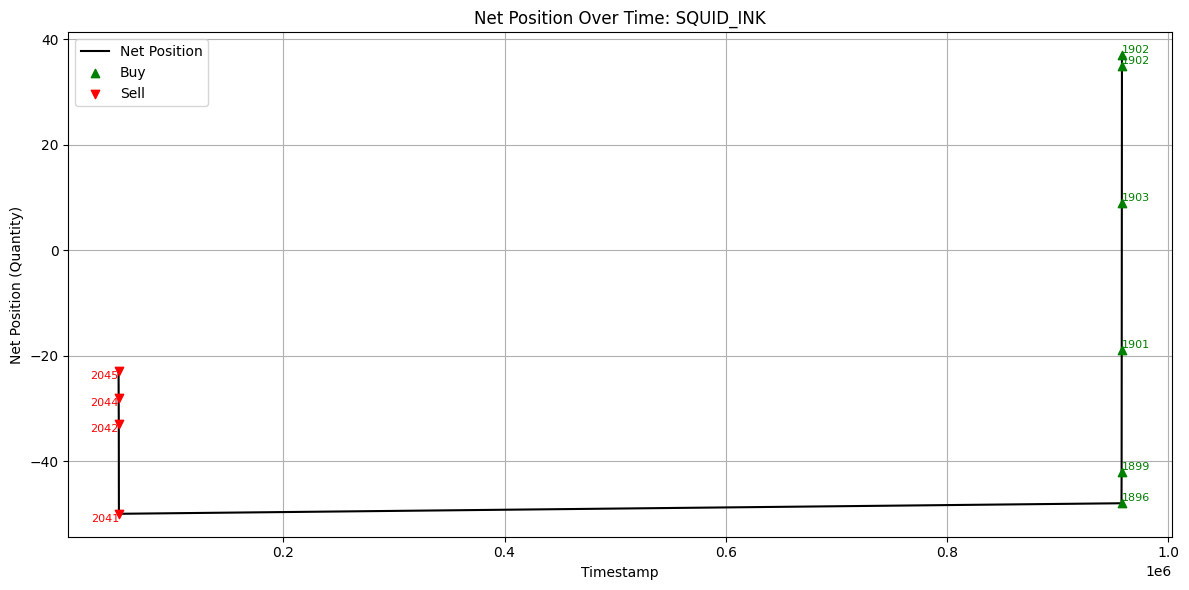

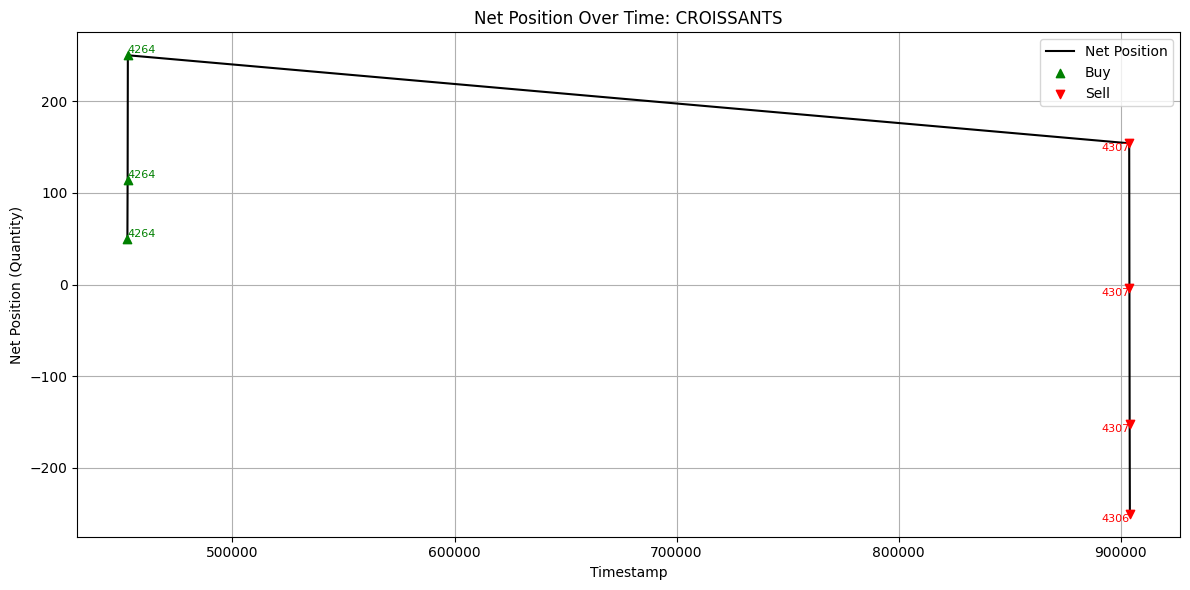

In [14]:
symbols = positions['symbol'].unique()

T_lo = 0
T_hi = 1000000

for sym in symbols:
    sym_df = positions[(positions['symbol'] == sym) & (T_lo <= positions['timestamp']) & (positions['timestamp'] <= T_hi)]

    # Create figure
    plt.figure(figsize=(12, 6))
    plt.plot(sym_df['timestamp'], sym_df['position'], linestyle='-', color='black', label='Net Position')

    # Plot trade points
    buys = sym_df[sym_df['signed_qty'] > 0]
    sells = sym_df[sym_df['signed_qty'] < 0]

    plt.scatter(buys['timestamp'], buys['position'], color='green', label='Buy', marker='^', zorder=5)
    plt.scatter(sells['timestamp'], sells['position'], color='red', label='Sell', marker='v', zorder=5)

    # Annotate prices
    for _, row in buys.iterrows():
        plt.text(row['timestamp'], row['position'], f"{row['price']}", color='green', fontsize=8, ha='left', va='bottom')
    for _, row in sells.iterrows():
        plt.text(row['timestamp'], row['position'], f"{row['price']}", color='red', fontsize=8, ha='right', va='top')

    # Labels and legend
    plt.title(f'Net Position Over Time: {sym}')
    plt.xlabel('Timestamp')
    plt.ylabel('Net Position (Quantity)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
# Step 1: Read the log content
with open("trade.log", "r") as f:
    content = f.read()

# Step 2: Extract all Sandbox log blocks (each is a JSON object)
entries = re.findall(r'\{\s*"sandboxLog":.*?"timestamp":\s*\d+\s*\}', content, re.DOTALL)

records = []

for entry in entries:
    try:
        data = json.loads(entry)
        timestamp = data["timestamp"]
        lambda_log = data.get("lambdaLog", "")

        # Extract z_score only
        z_score_match = re.search(r'z_score:\s*([-\d.]+)', lambda_log)
        z_score = float(z_score_match.group(1)) if z_score_match else None

        records.append({
            "timestamp": timestamp,
            "z_score": z_score,
        })
    except Exception as e:
        print(f"Skipping invalid entry: {e}")

# Step 3: Convert to DataFrame
df = pd.DataFrame(records).sort_values("timestamp").reset_index(drop=True)

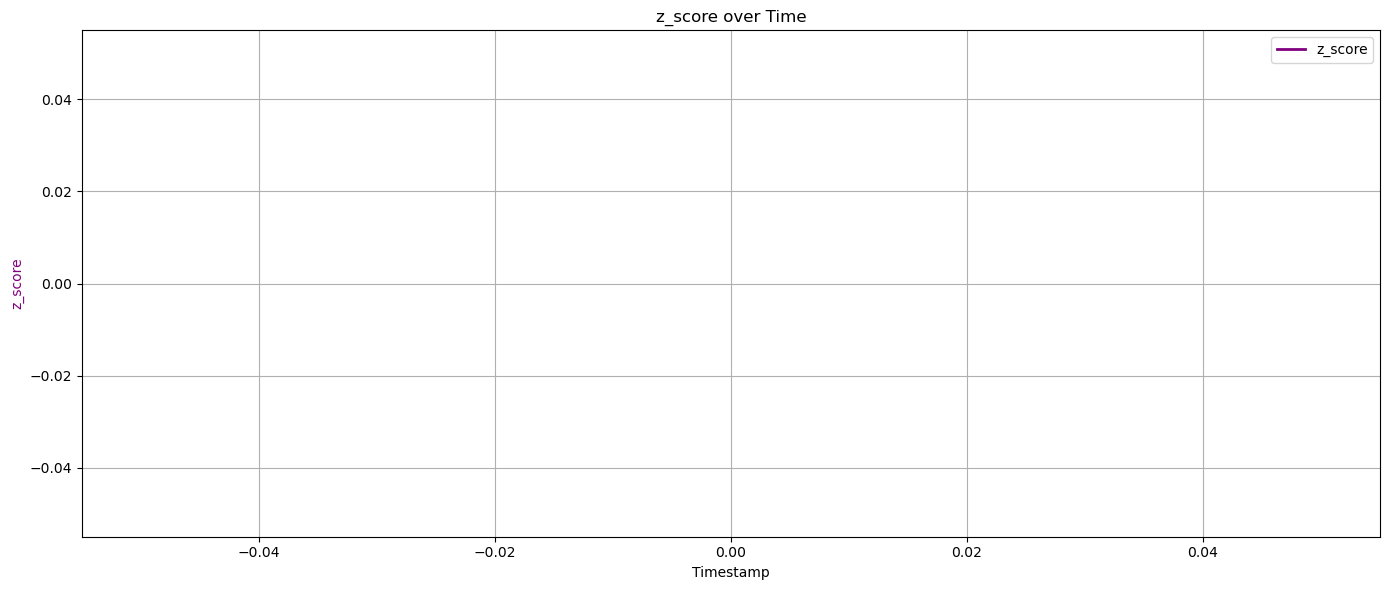

In [7]:
# Step 4: Plot z_score over time
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['z_score'], label='z_score', color='purple', linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("z_score", color='purple')
plt.title("z_score over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()